In [2]:
import json
from pathlib import Path
from io import BytesIO

import pandas as pd
import numpy as np
import nfl_data_py as nfl

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

import requests

In [3]:
pbp = nfl.import_pbp_data([2025])
sched = nfl.import_schedules([2025])

2025 done.
Downcasting floats.


In [4]:
sched.groupby("away_team").size()

away_team
ARI    9
ATL    9
BAL    8
BUF    8
CAR    9
CHI    9
CIN    8
CLE    8
DAL    9
DEN    8
DET    9
GB     9
HOU    8
IND    8
JAX    8
KC     8
LA     9
LAC    8
LV     8
MIA    8
MIN    9
NE     8
NO     9
NYG    9
NYJ    8
PHI    9
PIT    8
SEA    9
SF     9
TB     9
TEN    8
WAS    9
dtype: int64

## 1. Turnover Margin vs. Wins

In [5]:
# Load cached logo URL mapping: {"BAL": "https://...", ...}
TEAM_LOGOS = json.loads(Path("team_logos.json").read_text())

# (Helps avoid occasional 403s when downloading images)
HEADERS = {
    "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome Safari",
    "Referer": "https://en.wikipedia.org/",
}

In [6]:
# Keep only regular season
pbp_reg = pbp[pbp["season_type"] == "REG"].copy()

# Turnovers are interceptions or fumbles lost
tos = pbp_reg[(pbp_reg["interception"] == 1) | (pbp_reg["fumble_lost"] == 1)].copy()

# Offense commits turnover (giveaways)
giveaways = tos.groupby("posteam").size().rename("giveaways")

# Defense forces turnover (takeaways)
takeaways = tos.groupby("defteam").size().rename("takeaways")

to_df = pd.concat([takeaways, giveaways], axis=1).fillna(0)
to_df["turnover_margin"] = to_df["takeaways"] - to_df["giveaways"]
to_df.index.name = "team"

to_df.head()


,takeaways,giveaways,turnover_margin
team,,,
ARI,16,17,-1
ATL,16,16,0
BAL,17,19,-2
BUF,19,17,2
CAR,17,18,-1


Wins per team

In [7]:
sched_reg = sched[sched["game_type"] == "REG"].copy()

# Determine winner per game
sched_reg["home_win"] = sched_reg["home_score"] > sched_reg["away_score"]
sched_reg["away_win"] = sched_reg["away_score"] > sched_reg["home_score"]

home_wins = sched_reg.groupby("home_team")["home_win"].sum().rename("home_wins")
away_wins = sched_reg.groupby("away_team")["away_win"].sum().rename("away_wins")

wins = home_wins.add(away_wins, fill_value=0).rename("wins")
wins.index.name = "team"

wins.head()


team
ARI     3
ATL     5
BAL     7
BUF    10
CAR     7
Name: wins, dtype: int64

In [8]:
df = (
    to_df[["turnover_margin"]]
    .join(wins, how="inner")
    .reset_index()
    .sort_values("wins", ascending=False)
)

df.head()

,team,turnover_margin,wins
27,SEA,1,12
9,DEN,2,12
16,LA,9,11
21,NE,0,11
3,BUF,2,10


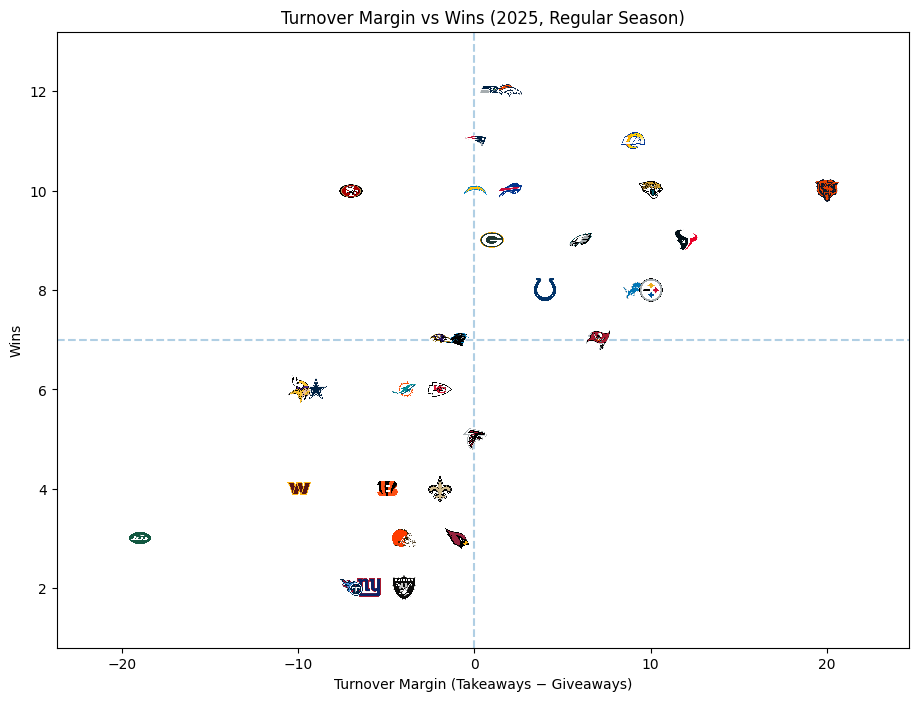

In [9]:
def logo_image(url: str, zoom: float = 0.07) -> OffsetImage:
    r = requests.get(url, headers=HEADERS, timeout=30)
    r.raise_for_status()
    img = mpimg.imread(BytesIO(r.content), format="png")
    return OffsetImage(img, zoom=zoom)

fig, ax = plt.subplots(figsize=(11, 8))

ax.set_title(f"Turnover Margin vs Wins (2025, Regular Season)")
ax.set_xlabel("Turnover Margin (Takeaways − Giveaways)")
ax.set_ylabel("Wins")

# Transparent scatter just to set axis limits cleanly
ax.scatter(df["turnover_margin"], df["wins"], alpha=0)

# Reference lines
ax.axvline(0, linestyle="--", alpha=0.35)
ax.axhline(df["wins"].mean(), linestyle="--", alpha=0.35)

# Add logos at each point
for _, row in df.iterrows():
    team = row["team"]
    url = TEAM_LOGOS.get(team)

    # Fallback: if logo missing, just skip or use text
    if not url:
        ax.text(row["turnover_margin"], row["wins"], team, fontsize=9)
        continue

    try:
        ab = AnnotationBbox(
            logo_image(url, zoom=0.065),  # tweak zoom if crowded
            (row["turnover_margin"], row["wins"]),
            frameon=False
        )
        ax.add_artist(ab)
    except Exception:
        # If download/parse fails, fallback to text label
        ax.text(row["turnover_margin"], row["wins"], team, fontsize=9)

ax.margins(0.12)  # helps prevent edge logos being cut off
plt.show()


## 2. Red zone efficiency ranking

In [10]:
rz = pbp[
    (pbp["season_type"] == "REG") &
    (pbp["yardline_100"] <= 20) &
    ((pbp["pass"] == 1) | (pbp["rush"] == 1))
]

In [11]:
rz_summary = (
    rz.groupby("posteam")
    .agg(
        rz_plays=("play_id", "count"),
        rz_tds=("touchdown", "sum")
    )
)

rz_summary["td_rate"] = rz_summary["rz_tds"] / rz_summary["rz_plays"]
rz_summary = rz_summary.sort_values("td_rate", ascending=False)


<Axes: title={'center': 'Top 15 Red Zone Touchdown Rates (2025)'}, xlabel='Touchdown Rate', ylabel='Team'>

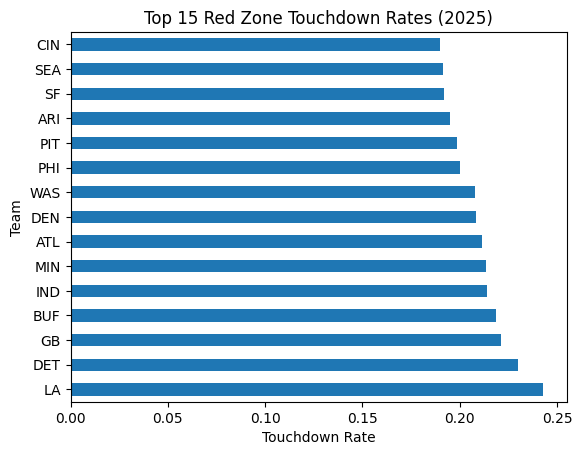

In [12]:
rz_summary["td_rate"].head(15).plot(
    kind="barh",
    title="Top 15 Red Zone Touchdown Rates (2025)",
    xlabel="Touchdown Rate",
    ylabel="Team"
)


## 3. Fourth down agression

In [13]:
fourth = pbp[
    (pbp["season_type"] == "REG") &
    (pbp["down"] == 4) &
    (pbp["yardline_100"].between(20, 80))
]


In [14]:
fourth["go_for_it"] = ~fourth["play_type"].isin(["punt", "field_goal"])

/var/folders/mk/354ykzvd4xb9dv44bwrmk9w80000gn/T/ipykernel_93364/3921050256.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fourth["go_for_it"] = ~fourth["play_type"].isin(["punt", "field_goal"])


In [15]:
fourth["ydstogo_bin"] = pd.cut(
    fourth["ydstogo"],
    bins=[0, 2, 5, 10, 100]
)

heatmap_data = (
    fourth
    .groupby(["ydstogo_bin", "yardline_100"])["go_for_it"]
    .mean()
    .unstack()
)

/var/folders/mk/354ykzvd4xb9dv44bwrmk9w80000gn/T/ipykernel_93364/3242503893.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fourth["ydstogo_bin"] = pd.cut(


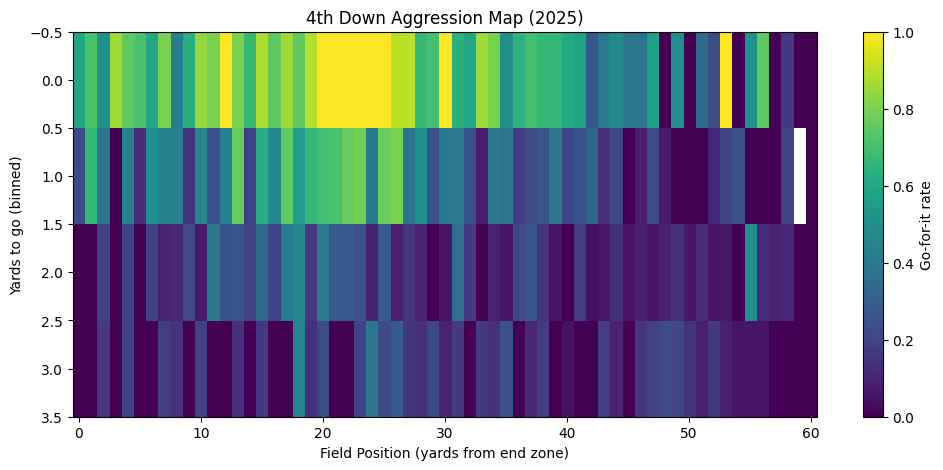

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.imshow(heatmap_data, aspect="auto")
plt.colorbar(label="Go-for-it rate")
plt.title("4th Down Aggression Map (2025)")
plt.xlabel("Field Position (yards from end zone)")
plt.ylabel("Yards to go (binned)")
plt.show()


## 4. Passing rate vs. efficiency

In [17]:
pbp_reg = pbp[pbp["season_type"] == "REG"].copy()

off_plays = pbp_reg[(pbp_reg["pass"] == 1) | (pbp_reg["rush"] == 1)]

team_off = (
    off_plays
    .groupby("posteam")
    .agg(
        plays=("play_id", "count"),
        pass_plays=("pass", "sum"),
        yards=("yards_gained", "sum")
    )
)

team_off["pass_rate"] = team_off["pass_plays"] / team_off["plays"]
team_off["yards_per_play"] = team_off["yards"] / team_off["plays"]

team_off = team_off.reset_index().rename(columns={"posteam": "team"})


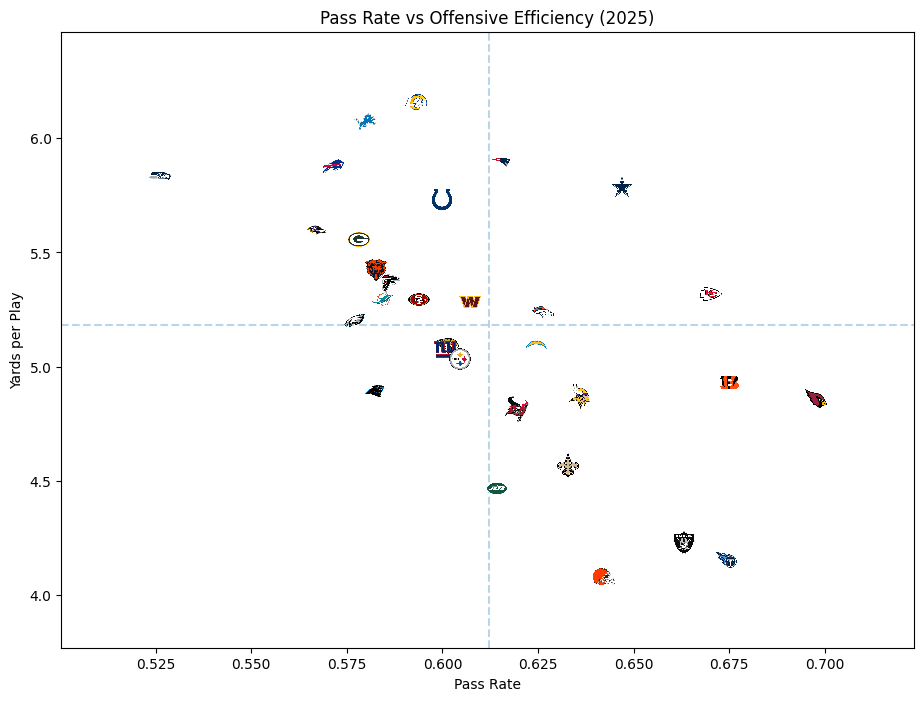

In [18]:
fig, ax = plt.subplots(figsize=(11, 8))

ax.set_title("Pass Rate vs Offensive Efficiency (2025)")
ax.set_xlabel("Pass Rate")
ax.set_ylabel("Yards per Play")

ax.scatter(team_off["pass_rate"], team_off["yards_per_play"], alpha=0)

for _, row in team_off.iterrows():
    team = row["team"]
    url = TEAM_LOGOS.get(team)
    if not url:
        continue

    ab = AnnotationBbox(
        logo_image(url, zoom=0.06),
        (row["pass_rate"], row["yards_per_play"]),
        frameon=False
    )
    ax.add_artist(ab)

ax.axvline(team_off["pass_rate"].mean(), linestyle="--", alpha=0.3)
ax.axhline(team_off["yards_per_play"].mean(), linestyle="--", alpha=0.3)

ax.margins(0.15)
plt.show()


## 5. Offense and Defense Efficiency

In [19]:
team_eff = (
    off_plays
    .groupby("posteam")
    .agg(
        off_ypp=("yards_gained", "mean")
    )
    .rename_axis("team")
)

def_plays = off_plays.copy()
def_plays["team"] = def_plays["defteam"]

def_eff = (
    def_plays
    .groupby("team")
    .agg(
        def_ypp=("yards_gained", "mean")
    )
)

eff = team_eff.join(def_eff)
eff = eff.join(wins)  # wins from earlier
eff = eff.reset_index()


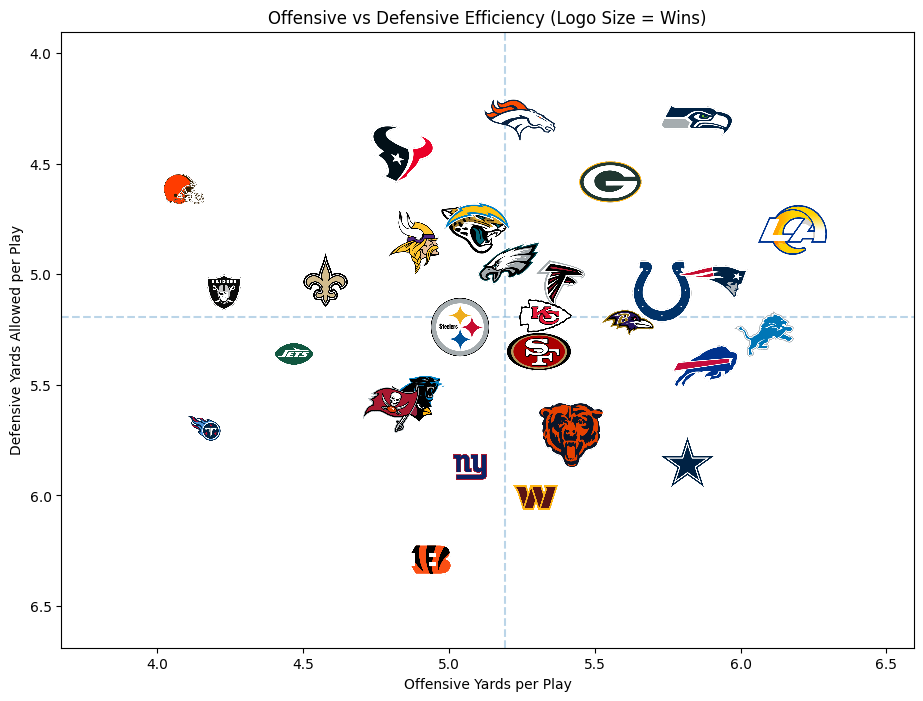

In [20]:
MIN_ZOOM = 0.02
MAX_ZOOM = 0.2
def win_scaled_logo(url, wins, max_wins):
    scaled = np.sqrt(wins / max_wins)
    zoom = MIN_ZOOM + scaled * (MAX_ZOOM - MIN_ZOOM)
    return logo_image(url, zoom=zoom)

MAX_WINS = eff["wins"].max()

fig, ax = plt.subplots(figsize=(11, 8))
ax.set_title("Offensive vs Defensive Efficiency (Logo Size = Wins)")
ax.set_xlabel("Offensive Yards per Play")
ax.set_ylabel("Defensive Yards Allowed per Play")

ax.scatter(eff["off_ypp"], eff["def_ypp"], alpha=0)

for _, row in eff.iterrows():
    team = row["team"]
    url = TEAM_LOGOS.get(team)
    if not url:
        continue

    ab = AnnotationBbox(
        win_scaled_logo(url, row["wins"], MAX_WINS),
        (row["off_ypp"], row["def_ypp"]),
        frameon=False
    )
    ax.add_artist(ab)

ax.axvline(eff["off_ypp"].mean(), linestyle="--", alpha=0.3)
ax.axhline(eff["def_ypp"].mean(), linestyle="--", alpha=0.3)
ax.invert_yaxis()
ax.margins(0.2)

plt.show()




## 6. Consistency - Points scored volatility vs wins

In [21]:
games = sched.copy()

home = games[["home_team", "home_score"]].rename(
    columns={"home_team": "team", "home_score": "points"}
)
away = games[["away_team", "away_score"]].rename(
    columns={"away_team": "team", "away_score": "points"}
)

points = pd.concat([home, away], ignore_index=True)


In [22]:
consistency = (
    points
    .groupby("team")
    .agg(
        avg_points=("points", "mean"),
        std_points=("points", "std")
    )
)

consistency = consistency.join(wins).reset_index()


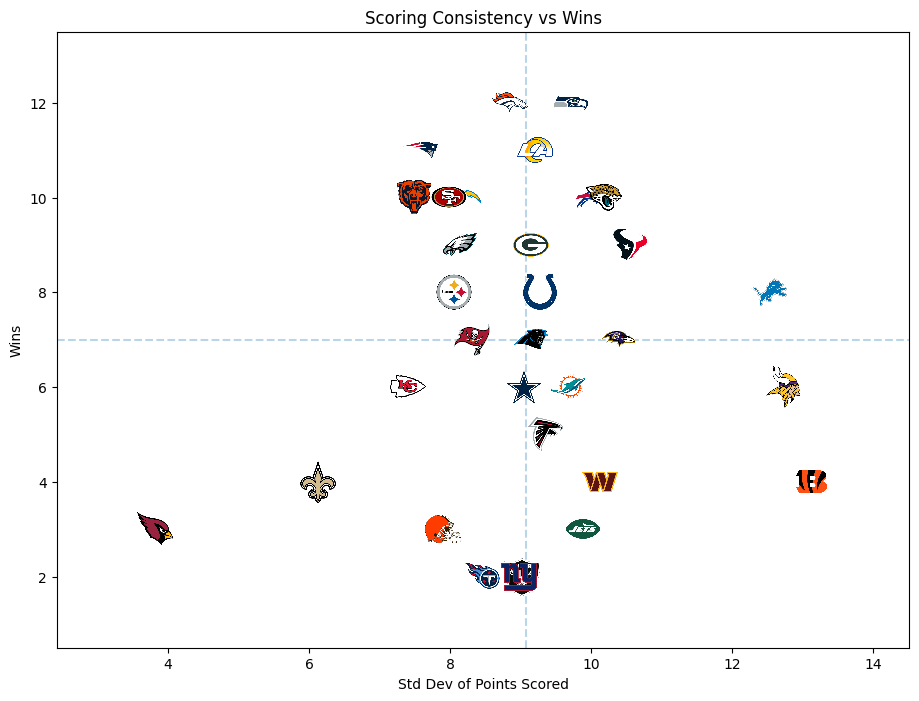

In [24]:
fig, ax = plt.subplots(figsize=(11, 8))

ax.set_title("Scoring Consistency vs Wins")
ax.set_xlabel("Std Dev of Points Scored")
ax.set_ylabel("Wins")

ax.scatter(consistency["std_points"], consistency["wins"], alpha=0)

for _, row in consistency.iterrows():
    team = row["team"]
    url = TEAM_LOGOS.get(team)
    if not url:
        continue

    ab = AnnotationBbox(
        logo_image(url, zoom=0.10),
        (row["std_points"], row["wins"]),
        frameon=False
    )
    ax.add_artist(ab)

ax.axvline(consistency["std_points"].mean(), linestyle="--", alpha=0.3)
ax.axhline(consistency["wins"].mean(), linestyle="--", alpha=0.3)

ax.margins(0.15)
plt.show()
